In [57]:
import tensorflow as tf
import numpy as np 
import pandas as pd
import os
import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras import regularizers
from keras.utils import to_categorical


In [58]:
# Load the data into a pandas DataFrame
print(os.getcwd())
df = pd.read_csv(
    filepath_or_buffer=os.getcwd()+'/../../data/monks/monks-1.train',
    names=['target', 'col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'id'],
    delimiter=' '
)

# Display the loaded data
df

/Users/gianlucapanzani/Documents/GitHub/Machine_Learning_Project/frameworks/tfkeras


,target,col1,col2,col3,col4,col5,col6,id
NaN,1,1,1,1,1,3,1,data_5
NaN,1,1,1,1,1,3,2,data_6
NaN,1,1,1,1,3,2,1,data_19
NaN,1,1,1,1,3,3,2,data_22
NaN,1,1,1,2,1,2,1,data_27
...,...,...,...,...,...,...,...,...
NaN,1,3,3,2,1,4,2,data_416
NaN,1,3,3,2,3,1,2,data_426
NaN,1,3,3,2,3,2,2,data_428
NaN,1,3,3,2,3,3,2,data_430


In [59]:
# Initializing labels/targets vector
y = df['target'].values.astype(float)

# Drop of the IDs and the targets
df = df.drop(columns=['target','id'], axis=1)

# Initializing the one-hot DataFrame
df_copy = df.copy(deep=True)

# Iteration on the columns of the DataFrame
for column in df.columns:

    # Creation of the one-hot encoding's columns
    df_one_hot = pd.get_dummies(df[column], dtype=float)

    # Change the name of the columns
    df_one_hot = df_one_hot.set_axis([column+'_'+str(col) for col in df_one_hot.columns], axis=1)

    # Drop of the initial column
    df_copy.drop(labels=column, axis=1, inplace=True)

    # Concatenation of the new columns to the DataFrame
    df_copy = pd.concat([df_copy,df_one_hot], axis=1)


# Columns to drop
#columns_to_drop = ['col1_2', 'col1_3',	'col2_2', 'col2_3',  'col3_2',  'col4_2', 'col4_3', 'col5_2', 'col5_3', 'col5_4', 'col6_2']

# Drop the specified columns
#df_copy = df_copy.drop(columns=columns_to_drop)

# Print of the obtained DataFrame   col1_2	col1_3	 col2_2	col2_3  col3_2	col3_3  col4_2	col4_3	col5_2	col5_3 col6_2		
df_copy

,col1_1,col1_2,col1_3,col2_1,col2_2,col2_3,col3_1,col3_2,col4_1,col4_2,col4_3,col5_1,col5_2,col5_3,col5_4,col6_1,col6_2
NaN,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
NaN,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
NaN,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
NaN,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
NaN,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
NaN,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
NaN,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
NaN,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [60]:
# Parameters' space for Grid Search     
param_space = {
    'input_units': [17],
    'units': [3, 4],
    'optimizer': ['sgd'],
    'learning_rate': [0.2, 0.3],
    'batch_size': [128],
    'epochs': [400],
    'weight_decay': [0.001,0.002],
    'momentum': [0.5, 0.6],
    'loss': ['binary_crossentropy'],
    'activation': ['tanh'],
    'output_activation': ['sigmoid'],
    'metrics': ['accuracy']
}

# Parameters' space for Grid Search (accuracy=0.89)
#param_space = {
    #'units': [3, 4],
    #'optimizer': ['sgd'],
    #'learning_rate': [0.01, 0.05, 0.1, 0.2],
    #'batch_size': [15, 16, 17],
    #'epochs': [1250, 1500, 1750],
    #'weight_decay': [0.005, 0.01],
    #'momentum': [0.7, 0.8, 0.9],
    #'loss': ['binary_crossentropy'] #['log_loss', 'binary_crossentropy']
#}

## Model Selection

# K-fold Cross Validation 

In [62]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.callbacks import EarlyStopping

# Parameters' space for Grid Search
param_space = {
    'input_units': [17],
    'units': [3, 4],
    'optimizer': ['sgd'],
    'learning_rate': [0.2, 0.3],
    'batch_size': [64, 128],
    'epochs': [300, 400, 500],
    'weight_decay': [0.001, 0.002],
    'momentum': [0.5, 0.6],
    'activation': ['tanh', 'relu'],
    'metrics': ['accuracy']
}

# Assigning new DataFrame to Data set variable
X = df_copy.values

# Number of trials with random combinations
num_trials = 15

# K-fold Cross-validation
k = 5
kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Lists to store training and validation accuracies
training_accuracies = []
validation_accuracies = []

# Lists to store best hyperparameters
best_hyperparameters = {
    'trial': 0,
    'params': {},
    'mean_validation_accuracy': 0
}

for i in range(num_trials):
    # Random parameters
    params = {
        'input_units': np.random.choice(param_space['input_units']),
        'units': np.random.choice(param_space['units']),
        'optimizer': np.random.choice(param_space['optimizer']),
        'learning_rate': np.random.choice(param_space['learning_rate']),
        'batch_size': np.random.choice(param_space['batch_size']),
        'epochs': np.random.choice(param_space['epochs']),
        'weight_decay': np.random.choice(param_space['weight_decay']),
        'momentum': np.random.choice(param_space['momentum']),
        'activation': np.random.choice(param_space['activation']),
        'metrics': np.random.choice(param_space['metrics']),
    }

    # Lists to store fold-wise accuracies
    fold_training_accuracies = []
    fold_validation_accuracies = []

    # For each K-fold returns the indexes of the data splitted in: <X_train,y_train> and <X_val,y_val>
    for train_index, val_index in kfold.split(X, y):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Build the model
        model = Sequential()
        model.add(Dense(units=params['input_units'], activation=params['activation'], use_bias=True))
        model.add(Dense(units=params['units'], activation=params['activation'], use_bias=True))
        model.add(Dense(units=1, activation='sigmoid', use_bias=True))

        # Set the optimizer with the sampled learning rate
        if params['optimizer'] == 'adam':
            opt = optimizers.Adam(learning_rate=params['learning_rate'])
        elif params['optimizer'] == 'sgd':
            opt = optimizers.SGD(learning_rate=params['learning_rate'], momentum=params['momentum'])
        else:
            raise ValueError("Unsupported optimizer")

        # Sets the Loss Function, the Optimizer used in the model, and the Metrics used for evaluation
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[params['metrics']])

        # Set the Early Stopping for the model
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        # Training of the model with validation split and early stopping
        history = model.fit(
            x=X_train,
            y=y_train,
            epochs=params['epochs'],
            batch_size=params['batch_size'],
            validation_data=(X_val, y_val),
            callbacks=[early_stopping],  # Add early stopping callback
            verbose=0
        )

        # Evaluate on both training and validation sets
        training_accuracy = model.evaluate(X_train, y_train, verbose=0)[1]
        validation_accuracy = model.evaluate(X_val, y_val, verbose=0)[1]

        fold_training_accuracies.append(training_accuracy)
        fold_validation_accuracies.append(validation_accuracy)

    # Calculate mean accuracies across folds for this trial
    mean_training_accuracy = np.mean(fold_training_accuracies)
    mean_validation_accuracy = np.mean(fold_validation_accuracies)

    # Store mean accuracies for this trial
    training_accuracies.append(mean_training_accuracy)
    validation_accuracies.append(mean_validation_accuracy)

    # Print mean accuracies and hyperparameters for this trial
    print(f"Trial {i+1}: Mean Training Accuracy={mean_training_accuracy:.4f}, Mean Validation Accuracy={mean_validation_accuracy:.4f}")
    print("Hyperparameters:", params)

    # Update best hyperparameters if current trial has higher validation accuracy
    if mean_validation_accuracy > best_hyperparameters['mean_validation_accuracy']:
        best_hyperparameters['trial'] = i + 1
        best_hyperparameters['params'] = params
        best_hyperparameters['mean_validation_accuracy'] = mean_validation_accuracy

# Print overall mean accuracies
print(f"\nOverall Mean Training Accuracy: {np.mean(training_accuracies):.4f}")
print(f"Overall Mean Validation Accuracy: {np.mean(validation_accuracies):.4f}")

# Print best hyperparameters
print("\nBest Hyperparameters:")
print("Trial:", best_hyperparameters['trial'])
print("Hyperparameters:", best_hyperparameters['params'])
print("Mean Validation Accuracy:", best_hyperparameters['mean_validation_accuracy'])


Trial 1: Mean Training Accuracy=0.9720, Mean Validation Accuracy=0.9180
Hyperparameters: {'input_units': 17, 'units': 3, 'optimizer': 'sgd', 'learning_rate': 0.2, 'batch_size': 128, 'epochs': 400, 'weight_decay': 0.001, 'momentum': 0.5, 'activation': 'tanh', 'metrics': 'accuracy'}


Trial 2: Mean Training Accuracy=0.9535, Mean Validation Accuracy=0.8960
Hyperparameters: {'input_units': 17, 'units': 4, 'optimizer': 'sgd', 'learning_rate': 0.2, 'batch_size': 64, 'epochs': 300, 'weight_decay': 0.002, 'momentum': 0.6, 'activation': 'tanh', 'metrics': 'accuracy'}


Trial 3: Mean Training Accuracy=1.0000, Mean Validation Accuracy=0.9920
Hyperparameters: {'input_units': 17, 'units': 4, 'optimizer': 'sgd', 'learning_rate': 0.3, 'batch_size': 64, 'epochs': 500, 'weight_decay': 0.001, 'momentum': 0.5, 'activation': 'tanh', 'metrics': 'accuracy'}


Trial 4: Mean Training Accuracy=0.9657, Mean Validation Accuracy=0.9120
Hyperparameters: {'input_units': 17, 'units': 4, 'optimizer': 'sgd', 'learning_rate': 0.3, 'batch_size': 64, 'epochs': 400, 'weight_decay': 0.001, 'momentum': 0.6, 'activation': 'tanh', 'metrics': 'accuracy'}


Trial 5: Mean Training Accuracy=0.7859, Mean Validation Accuracy=0.7273
Hyperparameters: {'input_units': 17, 'units': 4, 'optimizer': 'sgd', 'learning_rate': 0.2, 'batch_size': 128, 'epochs': 300, 'weight_decay': 0.001, 'momentum': 0.6, 'activation': 'relu', 'metrics': 'accuracy'}


Trial 6: Mean Training Accuracy=0.9798, Mean Validation Accuracy=0.9520
Hyperparameters: {'input_units': 17, 'units': 3, 'optimizer': 'sgd', 'learning_rate': 0.2, 'batch_size': 64, 'epochs': 500, 'weight_decay': 0.001, 'momentum': 0.6, 'activation': 'tanh', 'metrics': 'accuracy'}


Trial 7: Mean Training Accuracy=0.9840, Mean Validation Accuracy=0.9427
Hyperparameters: {'input_units': 17, 'units': 4, 'optimizer': 'sgd', 'learning_rate': 0.3, 'batch_size': 128, 'epochs': 400, 'weight_decay': 0.001, 'momentum': 0.5, 'activation': 'relu', 'metrics': 'accuracy'}


Trial 8: Mean Training Accuracy=0.9051, Mean Validation Accuracy=0.8553
Hyperparameters: {'input_units': 17, 'units': 3, 'optimizer': 'sgd', 'learning_rate': 0.2, 'batch_size': 128, 'epochs': 500, 'weight_decay': 0.001, 'momentum': 0.5, 'activation': 'relu', 'metrics': 'accuracy'}


Trial 9: Mean Training Accuracy=0.8990, Mean Validation Accuracy=0.7920
Hyperparameters: {'input_units': 17, 'units': 4, 'optimizer': 'sgd', 'learning_rate': 0.3, 'batch_size': 128, 'epochs': 400, 'weight_decay': 0.001, 'momentum': 0.6, 'activation': 'relu', 'metrics': 'accuracy'}


Trial 10: Mean Training Accuracy=0.9212, Mean Validation Accuracy=0.8233
Hyperparameters: {'input_units': 17, 'units': 3, 'optimizer': 'sgd', 'learning_rate': 0.2, 'batch_size': 128, 'epochs': 300, 'weight_decay': 0.001, 'momentum': 0.5, 'activation': 'relu', 'metrics': 'accuracy'}


Trial 11: Mean Training Accuracy=0.9798, Mean Validation Accuracy=0.9520
Hyperparameters: {'input_units': 17, 'units': 4, 'optimizer': 'sgd', 'learning_rate': 0.3, 'batch_size': 64, 'epochs': 300, 'weight_decay': 0.002, 'momentum': 0.6, 'activation': 'relu', 'metrics': 'accuracy'}


Trial 12: Mean Training Accuracy=0.9215, Mean Validation Accuracy=0.8463
Hyperparameters: {'input_units': 17, 'units': 3, 'optimizer': 'sgd', 'learning_rate': 0.2, 'batch_size': 64, 'epochs': 300, 'weight_decay': 0.002, 'momentum': 0.6, 'activation': 'tanh', 'metrics': 'accuracy'}


Trial 13: Mean Training Accuracy=1.0000, Mean Validation Accuracy=0.9030
Hyperparameters: {'input_units': 17, 'units': 4, 'optimizer': 'sgd', 'learning_rate': 0.2, 'batch_size': 128, 'epochs': 400, 'weight_decay': 0.002, 'momentum': 0.5, 'activation': 'relu', 'metrics': 'accuracy'}


Trial 14: Mean Training Accuracy=0.9416, Mean Validation Accuracy=0.8863
Hyperparameters: {'input_units': 17, 'units': 4, 'optimizer': 'sgd', 'learning_rate': 0.2, 'batch_size': 64, 'epochs': 300, 'weight_decay': 0.001, 'momentum': 0.5, 'activation': 'tanh', 'metrics': 'accuracy'}


Trial 15: Mean Training Accuracy=0.9011, Mean Validation Accuracy=0.8230
Hyperparameters: {'input_units': 17, 'units': 3, 'optimizer': 'sgd', 'learning_rate': 0.3, 'batch_size': 128, 'epochs': 400, 'weight_decay': 0.001, 'momentum': 0.5, 'activation': 'relu', 'metrics': 'accuracy'}

Overall Mean Training Accuracy: 0.9407
Overall Mean Validation Accuracy: 0.8814

Best Hyperparameters:
Trial: 3
Hyperparameters: {'input_units': 17, 'units': 4, 'optimizer': 'sgd', 'learning_rate': 0.3, 'batch_size': 64, 'epochs': 500, 'weight_decay': 0.001, 'momentum': 0.5, 'activation': 'tanh', 'metrics': 'accuracy'}
Mean Validation Accuracy: 0.9919999957084655


0.875
0.949999988079071
{'input_units': 17, 'units': 3, 'optimizer': 'sgd', 'learning_rate': 0.3, 'batch_size': 128, 'epochs': 400, 'weight_decay': 0.001, 'momentum': 0.5, 'activation': 'relu', 'metrics': 'accuracy'}


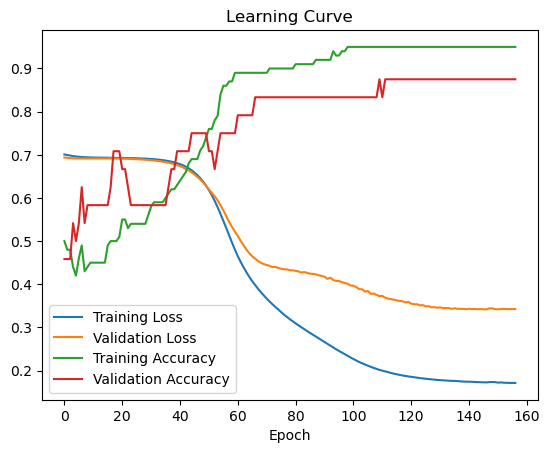

In [63]:
# Plot the learning curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.legend()
print(f"Validation accuracy: {validation_accuracy}")
print(f"Training accuracy: {training_accuracy}")
print(f"Hyperparameters: {params}")
